# Poisson Image Editing

In this notebook, the [poisson image editing](https://www.cs.virginia.edu/~connelly/class/2014/comp_photo/proj2/poisson.pdf) paper is implemented and studied. Possion image editting is ...

Our goal is to extract the Statue of Liberty from this image (the source image):
![The Statue of Liberty.](./figs/example1/source1.jpg)

And merge it to the target image:
![The ocean.](./figs/example1/target1.jpg)

The `./figs/mask1.jpg` is used to extract the Statue of Liberty part out from `./figs/source1.jpg`. This mask is a black and white image. When we apply it to `source1.jpg`, we'll filter out everything except for the Statue of Liberty and a little bit surrounding area. I will discuss how to generate this mask later. If we merge the extracted part directly to our target image, then we'll get:
![Direct merge.](./figs/example1/direct_merge1.png)

We can see apparently the statue is from another image. Note even if the mask is perfect, the result still won't be ideal, the boundary of the two images can be easily identified. Poisson image editing can be used to seamlessly blend these two images. 

When we directly merge the two image, we set the pixels in the merging region of the target image to be those of the source image. The pixel values accross the boundary will have sharp changes. One way is to set a transition region and make the pixel values change smoothly from one image to the other. In this way, the boundary will become less visible, but the colors and lighting will still be unnatural since we didn't make any changes outside this transition region around the boundary. 

Instead of copy-and-past, we interpolate the copied region by solving the Poisson equation. More specifically, Eq. (10) in [Pérez 2003] is used here for seamless cloning. Let $\mathbf{f}$ be the pixel values in the region to paste (which is what we're trying to solve), let $\mathbf{g}$ be the corresponding region in the source image. Instead of letting $\mathbf{f}=\mathbf{g}$, we let $\nabla \mathbf{f} = \nabla \mathbf{g}$, and let the pixel values on the boundary to be the same as those from the target image. In this way, the pixel values $\mathbf{f}$'s distribution is "guided" by the source image, and gradually blends to the target image on the boundary. More rigorous derivations can be found in [Pérez 2003], the main idea is to let the pixel values be the same on the boundary, and find a distribution that resembles the source image and changes to the target image smoothly.  

The only technical difficulty is to implement the Laplacian operator. [This](https://en.wikipedia.org/wiki/Discrete_Poisson_equation) is a good reference. We first build the matrix $\mathbf{D}$, then build matrix $\mathbf{A}$ by setting $\mathbf{D}$ as block diagonal element, and set the $\mathbf{I}$'s: 


In [1]:
import scipy.sparse
from scipy.sparse.linalg import spsolve
from PIL import Image
from random import randint
import numpy as np
import numpy.linalg as npl
def laplacian_matrix(n, m):   
    mat_D = scipy.sparse.lil_matrix((m, m))
    mat_D.setdiag(-1, -1)
    mat_D.setdiag(4)
    mat_D.setdiag(-1, 1)
        
    mat_A = scipy.sparse.block_diag([mat_D] * n).tolil()
    
    mat_A.setdiag(-1, 1*m)
    mat_A.setdiag(-1, -1*m)
    
    return mat_A

laplacian_matrix(3, 3).todense()

matrix([[ 4., -1.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
        [-1.,  4., -1.,  0., -1.,  0.,  0.,  0.,  0.],
        [ 0., -1.,  4.,  0.,  0., -1.,  0.,  0.,  0.],
        [-1.,  0.,  0.,  4., -1.,  0., -1.,  0.,  0.],
        [ 0., -1.,  0., -1.,  4., -1.,  0., -1.,  0.],
        [ 0.,  0., -1.,  0., -1.,  4.,  0.,  0., -1.],
        [ 0.,  0.,  0., -1.,  0.,  0.,  4., -1.,  0.],
        [ 0.,  0.,  0.,  0., -1.,  0., -1.,  4., -1.],
        [ 0.,  0.,  0.,  0.,  0., -1.,  0., -1.,  4.]])

Now our equation becomes:    
$\mathbf{Af} = \mathbf{Ag}$, inside the region;    
$\mathbf{f} = \mathbf{t}$, outside the region.

where $\mathbf{g}$ is the pixel value of the source image, $\mathbf{t}$ is the pixel value of the target image. 

Now we are ready to implement our Poisson editting algorithm. First, we load the images and the masks:

In [2]:
source_path='generated_images/croped_mixed/'
target_path='images_background/'
mask_path='generated_masks/croped_mixed'
mask='mask/'
img_path='images_background/'
masking_insapath= 'Masking_insa/output/mask/'


In [6]:
from os import path
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#scr_dir = 'figs/example1'
#source = cv2.imread(path.join(scr_dir, "source1.jpg")) 
#target = cv2.imread(path.join(scr_dir, "target1.jpg"))
#mask = cv2.imread(path.join(scr_dir, "mask1.png"), cv2.IMREAD_GRAYSCALE) 
#offset = (0, 66)


source = cv2.imread(path.join(source_path,'generated1.jpg'))
target = cv2.imread(path.join(target_path,'background1.jpg'))
target=target[0:72,0:74]
mask = cv2.imread(path.join(mask_path,'mask1.png'), cv2.IMREAD_GRAYSCALE) 
offset = (0, 0)

print('Source image size:', source.shape[:-1])
plt.imshow(source[:,:,::-1]) # this is a trick to display the image in here 
plt.show()
print('Target image size:', target.shape[:-1])
plt.imshow(target[:,:,::-1])
plt.show()
print('Mask size:', mask.shape)
plt.imshow(mask, cmap='gray')
plt.show()
print(source.shape[:-1][0])

AttributeError: 'NoneType' object has no attribute 'shape'

In [4]:
def GradientHor(x):
    y=x-np.roll(x,1,axis=1)
    y[:,0]=0
    return y
def GradientVer(x):
    y=x-np.roll(x,1,axis=0)
    y[0,:]=0
    return y
def DivHor(x):
    N=len(x[0])
    y=x-np.roll(x,-1,axis=1)
    y[:,0]=-x[:,1]
    y[:,N-1]=x[:,N-1]
    return y
def DivVer(x):
    N=len(x)
    y=x-np.roll(x,-1,axis=0)
    y[0,:]=-x[1,:]
    y[N-1,:]=x[N-1,:]
    return y
def Gradient(x):
    y=[]
    y.append(GradientHor(x))
    y.append(GradientVer(x))
    return y
def Div(y):
    x=DivHor(y[0])+DivVer(y[1])
    return x

def Proj(im,ma,iref):
    res = np.copy(iref) 
    mask = np.where(ma==1)
    res[mask]=im[mask]
    return res

def GradientFonc(x,y):
    res = Div(np.array(Gradient(x))-np.array(y))
    return res


def FISTAPoissonEditing(targ,sour,ma,step,alpha,Niter,y):
    x=np.copy(targ)
    mask=np.where(ma==1)
    x[mask]=sour[mask]
    f=[]
    x1 = x
    for i in range(0,Niter):
        x_tilde = x+i/(i+alpha)*(x-x1)
        x1 = x_tilde
        x = Proj(x_tilde - step * GradientFonc(x_tilde,y),ma,targ)
        f+=[npl.norm((np.array(Gradient(x))- y))**2]

    f=np.array(f)    
    return np.clip(x,0,255),f[10:]



def _mixing_gradient(target, source):

    grad_target = np.array(Gradient(target))
    norm_target = np.sqrt(grad_target[0]**2 + np.array(grad_target[1]**2)) # this gives a matrix = [norm(u,v)]_ij 

    grad_source = np.array(Gradient(source))
    norm_source = np.sqrt(grad_source[0]**2 + np.array(grad_source[1]**2)) # this gives a matrix = [norm(u,v)]_ij 
    
    targ_sup_sour = norm_target > norm_source 
    index = np.where(targ_sup_sour==True)
    #print(index[1].shape)
    #print(grad_source.shape)
    v = grad_source
    
    a = norm_target > norm_source
    for i, j in zip(range(grad_source.shape[0]),range(grad_source.shape[1])):
        if a[i,j]==True:
            v[i,j] = grad_target[i,j]
    return v

In [23]:
def poisson_generation(mask_path,img_path,N):
    #mask_path='mask/'
    #img_path='images_background/'
    
    for i in range(0,N):     
        b_rand=randint(0,3)#randomiser l'image de fond
        
        nb_chardon=randint(10,25)#nombre de chardons
        #nb_gangs=randint(2,4)
        #print(b_rand)
        background = Image.open(img_path+'background%d.jpg' %(b_rand))
        #bg_w, bg_h = background.size
        #bg = Image.new('RGB', (4056, 3040))
        
        file = open("generated_finale/coordinates%d.txt" %(i),"a")
        file.truncate(0)
        for j in range(nb_chardon):
            a_rand=randint(1,39)#randomiser la source
            posx=randint(1,nb_chardon)
            posy=randint(1,nb_chardon)
            sourceim=Image.open(path.join(source_path,'generated%d.jpg'%(a_rand)))
            target=Image.open(path.join(img_path,'background%d.jpg'%(b_rand)))
            target=target.crop([posx*sourceim.size[0],posy*sourceim.size[1],(posx+1)*sourceim.size[0],
                          (posy+1)*sourceim.size[1]])
            
            target=np.array(target).astype(float)
            source=np.array(Image.open(path.join(source_path,'generated%d.jpg'%(a_rand)))).astype(float)
            mask2=np.array(Image.open(path.join(mask_path,'mask%d.png'%(a_rand)))).astype(float)/255
            

            x = np.copy(source)
            target0=target[:,:,0]
            source0=source[:,:,0]
            target1=target[:,:,1]
            source1=source[:,:,1]
            target2=target[:,:,2]
            source2=source[:,:,2]
            y0 = _mixing_gradient(target0, source0)
            y1 = _mixing_gradient(target1, source1)
            y2 = _mixing_gradient(target2, source2)
            
            im0,f0=FISTAPoissonEditing(target0,source0,mask2,step=0.1,alpha=4,Niter=1000,y=y0)
            im1,f1=FISTAPoissonEditing(target1,source1,mask2,step=0.1,alpha=4,Niter=1000,y=y1)
            im2,f2=FISTAPoissonEditing(target2,source2,mask2,step=0.1,alpha=4,Niter=1000,y=y2)
            
            x[:,:,0] = im0
            x[:,:,1] = im1
            x[:,:,2] = im2

            out_dir="generated_poisson/"
            #plt.rcParams["figure.figsize"] = (30,30)
            #f, (ax1, ax2,ax3) = plt.subplots(1,3)
            #ax1.imshow(target/255)
            #ax2.imshow(source/255)
            #ax3.imshow(mask2,cmap="gray")
            #print(x)
            im = Image.fromarray((x).astype(np.uint8))
            im.save(path.join(out_dir, "poisson%d.jpg"%(j)))
            foreground=Image.open(out_dir+'poisson%d.jpg' %(j))
            background.paste(im,(posx*sourceim.size[0],posy*sourceim.size[1]))
            
            
           # file.write(str(posx*source.size[0])+" "+str(posy*source.size[1])+" "+str((posx+1)*source.size[0])+" "
                  #        ++" "+str((posy+1)*source.size[1])+ "\n")
                      # +" " +str((posx+1)*source.shape[:-1][0])+"\n")
        #source = cv2.warpAffine(source, M, (x_range, y_range))
        background.save('generated_finale/generated%d.jpg' %(i))
        file.close()

In [25]:
poisson_generation(mask_path,img_path,10)

In [ ]:
#b_rand=randint(1,4)#randomiser l'image de fond
        
        #nb_chardon=randint(10,25)#nombre de chardons
        #nb_gangs=randint(2,4)
        #print(b_rand)
        #background = Image.open(img_path+'background%d.jpg' %(b_rand))
        #bg_w, bg_h = background.size
        #bg = Image.new('RGB', (4056, 3040))
        
        #file = open("generated_finale/coordinates%d.txt" %(i),"a")
        #file.truncate(0)
        #for j in range(nb_chardon):
            #a_rand=randint(0,50)#randomiser la source
            source = cv2.imread(path.join(source_path,'generated%d.jpg'%(a_rand)))
            target = cv2.imread(path.join(img_path,'background%d.jpg'%(b_rand)))
            posx=randint(1,nb_chardon)
            posy=randint(1,nb_chardon)
            target=target[posx*source.shape[:-1][0]:(posx+1)*source.shape[:-1][0],
                          posy*source.shape[:-1][1]:(posy+1)*source.shape[:-1][1]]
            mask = cv2.imread(path.join(mask_path,'mask%d.png'%(a_rand)), cv2.IMREAD_GRAYSCALE) 
            x = np.copy(source)
            target0=target[:,:,0]
            source0=source[:,:,0]
            target1=target[:,:,1]
            source1=source[:,:,1]
            target2=target[:,:,2]
            source2=source[:,:,2]
            y0 = _mixing_gradient(target0, source0)
            y1 = _mixing_gradient(target1, source1)
            y2 = _mixing_gradient(target2, source2)
            im0,f0=FISTAPoissonEditing(target0,source0,mask,step=0.1,alpha=4,Niter=1000,y=y0)
            im1,f1=FISTAPoissonEditing(target1,source1,mask,step=0.1,alpha=4,Niter=1000,y=y1)
            im2,f2=FISTAPoissonEditing(target2,source2,mask,step=0.1,alpha=4,Niter=1000,y=y2)
            
            x[:,:,0] = im0
            x[:,:,1] = im1
            x[:,:,2] = im2
            
            out_dir = 'generated_poisson/'
            
            im = Image.fromarray(x)

Note the mask tells us what region to extract from the source image, when we insert to the target image, we may want to translate it, so we need an offset parameter. In here, I set the offset value directly, I'll talk about how to find the desired value later. 

Now we translate the source image according to the offset:

Source image size: (90, 76)


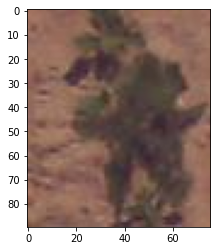

In [32]:
y_max, x_max = target.shape[:-1]
y_min, x_min = 0, 0
x_range = x_max - x_min
y_range = y_max - y_min

M = np.float32([[1, 0, offset[0]], [0, 1, offset[1]]])
#source = cv2.warpAffine(source, M, (x_range, y_range))

print('Source image size:', source.shape[:-1])
plt.imshow(source[:,:,::-1]) 
plt.show()

Convert the mask's value to {0, 1} (it was {0, 255}): 

In [33]:
mask = mask[y_min:y_max, x_min:x_max]
mask[mask != 0] = 1

Now we need to generate the matrix $\mathbf{A}$. First, apply our function to get the Laplacian matrix:

In [34]:
mat_A = laplacian_matrix(y_range, x_range)
laplacian = mat_A.tocsc()

We only want to apply the Laplacian operator inside the blending region, so for the outside part, we set it to identity. Note for each row in mat_A, if it takes the Laplacian, then the row will have a "4" on the diagonal and four "-1", so to set it to identity, we want to set the "4" to "1", and the rest to "0":

In [35]:
for y in range(1, y_range - 1):
    for x in range(1, x_range - 1):
        if mask[y, x] == 0:
            k = x + y * x_range
            mat_A[k, k] = 1
            mat_A[k, k + 1] = 0
            mat_A[k, k - 1] = 0
            mat_A[k, k + x_range] = 0
            mat_A[k, k - x_range] = 0
mat_A = mat_A.tocsc()

Now

In [36]:


mask_flat = mask.flatten()    
for channel in range(source.shape[2]):
    source_flat = source[y_min:y_max, x_min:x_max, channel].flatten()
    target_flat = target[y_min:y_max, x_min:x_max, channel].flatten()        

    # inside the mask:
    # \Delta f = div v = \Delta g       
    alpha = 1
    mat_b = laplacian.dot(source_flat)*alpha

    # outside the mask:
    # f = t
    mat_b[mask_flat == 0] = target_flat[mask_flat == 0]
    
    x = spsolve(mat_A, mat_b)    
    x = x.reshape((y_range, x_range))
    x[x > 255] = 255
    x[x < 0] = 0
    x = x.astype('uint8')
    
    target[y_min:y_max, x_min:x_max, channel] = x

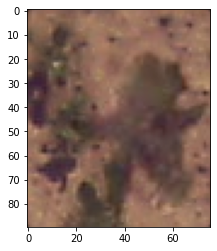

False

In [37]:
plt.imshow(target[:,:,::-1]) 
plt.show()

out_dir = 'figs'
cv2.imwrite(path.join(out_dir, "possion1.png"), target)

In [17]:
from PIL import Image
#import tensorflow.keras.preprocessing.image as kpi
from random import randint
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [18]:
# Open overlay image
img = Image.open('poisson1.png')

img_w, img_h = img.size
background = Image.open('background2.jpg')
bg_w, bg_h = background.size
#offset = ((bg_w - img_w) // 2, (bg_h - img_h) // 2)
background.paste(img,(2435 -50,420-100))
background.save('result.png')
background.show()

FileNotFoundError: [Errno 2] No such file or directory: 'poisson1.png'

# Reference

Patrick Pérez, Michel Gangnet, and Andrew Blake. 2003. *Poisson image editing*. ACM Trans. Graph. 22, 3 (July 2003), 313-318. DOI: https://doi.org/10.1145/882262.882269